In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
import torch.utils.data
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
# from torchvision.utils import save_image

from vae_conv import conv_variational_autoencoder 
from data import DatasetCM, triu_to_full
import sys, os, tables 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# h5_file = '../../2F4K-0/data/2f4k_data.h5'
h5_file = '../../NCBD/data/1kbh_data.h5'

In [3]:
cm_dataset = DatasetCM(h5_file, transform=transforms.ToTensor()) 
train_set, test_set = torch.utils.data.random_split(cm_dataset, (int(0.8*len(cm_dataset)), len(cm_dataset) - int(0.8*len(cm_dataset))))

In [4]:
np.squeeze(cm_dataset[1000]).shape

torch.Size([106, 106])

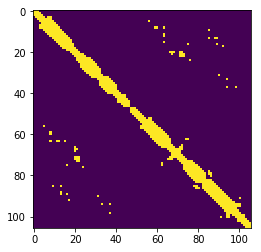

In [5]:
plt.imshow(np.squeeze(cm_dataset[1000]))

In [14]:
batch_size = len(train_set)/50
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)   

In [15]:
channels = cm_dataset.shape[-1]
# batch_size = cm_train.shape[0]/100
conv_layers = 4 
feature_maps = [64,64,64,64]
filter_shapes = [3,3,3,3]
strides = [1,2,1,1]
# dense_layers = 2
# dense_neurons = [128, 64]
# dense_dropouts = [0.0, 0.0]
dense_layers = 1
dense_neurons = [128]
dense_dropouts = [0.0]
latent_dim = 10

image_size = cm_dataset.shape[1] 

In [16]:
autoencoder = conv_variational_autoencoder(image_size,channels,conv_layers,feature_maps,
                                           filter_shapes,strides,dense_layers,dense_neurons,dense_dropouts,latent_dim, log_interval = 10000)

In [ ]:
epochs = 100

for epoch in range(1, epochs + 1): 
    train_loss = autoencoder.train(train_loader, epoch) 
    test_loss = autoencoder.test(test_loader, epoch) 
#     if train_loss < test_loss: 
#         print('Train stopped to avoid overtraining...')
#         break
#     with torch.no_grad(): 
#         train_all = train_loader.dataset.train_data.reshape(-1, 1, 28, 28).float()[:2000].to(device)
# #         print(train_all.shape)
#         decoded = autoencoder.predict(train_all) 
#         embeded = autoencoder.return_embeddings(train_all) 
#         encoded = autoencoder.encode(train_all) 
    
#     plt.figure(figsize=(10,8))
#     plt.scatter(embeded.cpu()[:2000,0], embeded.cpu()[:2000,1], c=train_loader.dataset.train_labels.cpu()[:2000], cmap='tab10') 
#     plt.title('Epoch: %d' % epoch)
#     plt.colorbar() 
#     plt.savefig('./results/3_result_epoch%d.pdf' % epoch) 

Train Epoch: 1 [0/8626 (0%)]	Loss: 361.332940
====> Epoch: 1 Average loss: 354.9028 ====> Test set loss: 354.9859
Train Epoch: 2 [0/8626 (0%)]	Loss: 347.838822
====> Epoch: 2 Average loss: 343.2283 ====> Test set loss: 319.3953
Train Epoch: 3 [0/8626 (0%)]	Loss: 336.346362
====> Epoch: 3 Average loss: 292.5402 ====> Test set loss: 272.0976
Train Epoch: 4 [0/8626 (0%)]	Loss: 267.970680
====> Epoch: 4 Average loss: 249.6031 ====> Test set loss: 237.1687
Train Epoch: 5 [0/8626 (0%)]	Loss: 231.939907
====> Epoch: 5 Average loss: 222.2250 ====> Test set loss: 213.3513
Train Epoch: 6 [0/8626 (0%)]	Loss: 209.520099
====> Epoch: 6 Average loss: 202.1608 ====> Test set loss: 197.4652
Train Epoch: 7 [0/8626 (0%)]	Loss: 197.546148
====> Epoch: 7 Average loss: 188.4578 ====> Test set loss: 187.4330
Train Epoch: 8 [0/8626 (0%)]	Loss: 189.851381
====> Epoch: 8 Average loss: 178.3245 ====> Test set loss: 176.8202
Train Epoch: 9 [0/8626 (0%)]	Loss: 172.421171
====> Epoch: 9 Average loss: 170.3366 ====

In [36]:
import h5py 
cm_h5 = h5py.File(h5_file, 'r') 
Rgyr = cm_h5['Rg']

In [19]:
labels.shape

(10783, 2)

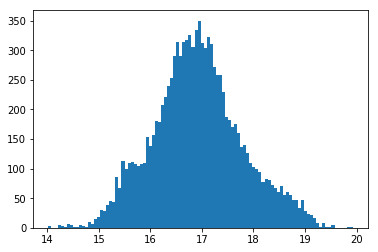

In [20]:
hist, _, _ = plt.hist(labels[:,1], bins=100)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad(): 
    train_all = torch.tensor(cm_dataset.data).reshape(-1, 1, 106, 106).float()
    data_loader = torch.utils.data.DataLoader(train_all, batch_size=batch_size, shuffle=False) 
    embedded_list = []
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device, dtype=torch.float)
#         decoded = autoencoder.predict(data) 
        embedded = autoencoder.return_embeddings(data) 
#         encoded = autoencoder.encode(data) 
        embedded_list.append(embedded.cpu().numpy())
# embedded_list = np.array(embedded_list)        

In [33]:
embedded_list = np.array(embedded_list) 
embedded_list = np.vstack(embedded_list)
embedded_list.shape

(10783, 10)

In [34]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(embedded_list)

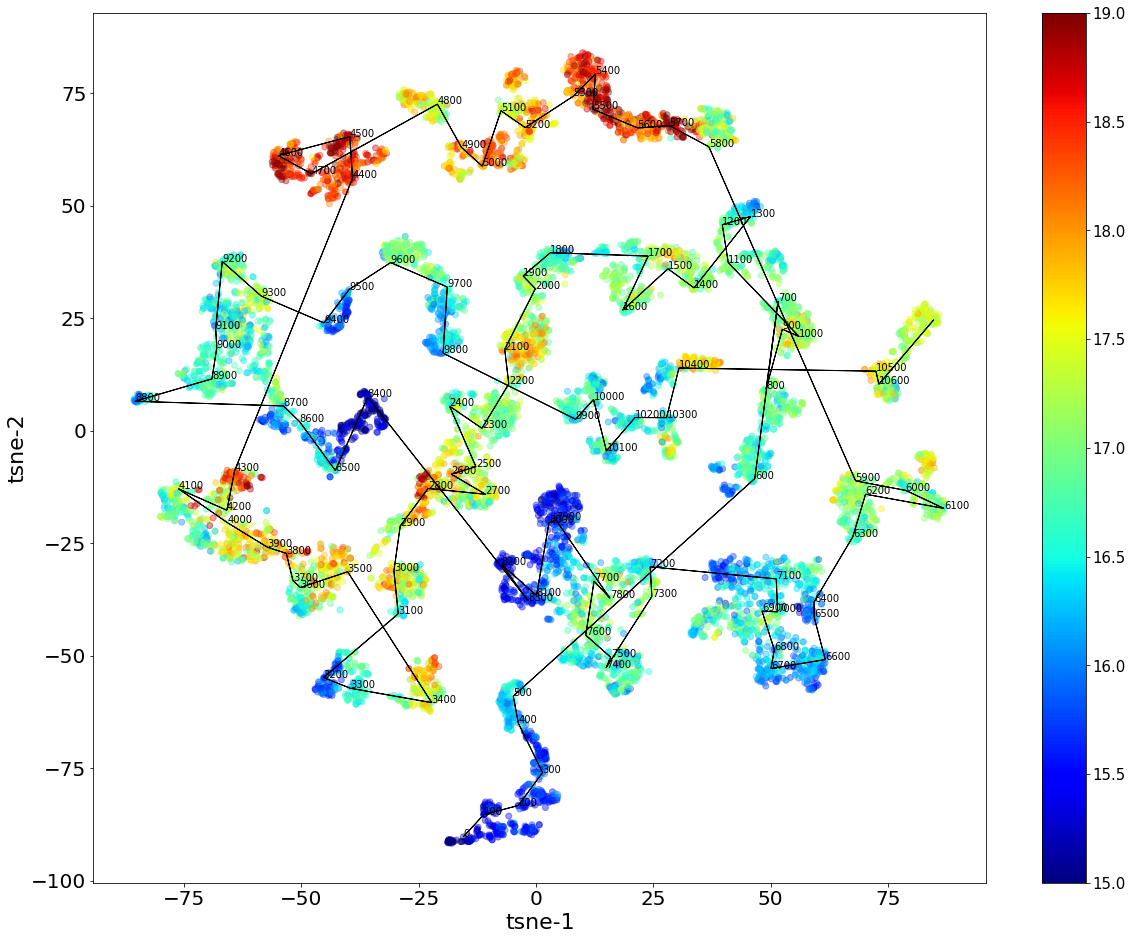

In [37]:
fig = plt.figure(figsize=(20,16))
# ax = fig.add_subplot(111, projection='3d')
color = Rgyr[:,1] # np.array(cm_label[:,2])
base = plt.cm.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=15, vmax=19)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=base)

plt.scatter(X_embedded[:,0], X_embedded[:,1], cmap='jet',
             c=scalarMap.to_rgba(color), alpha=0.4) 
for i in range(0, len(X_embedded)-100,100): 
    plt.text(X_embedded[i,0], X_embedded[i,1], str(i))
    plt.arrow(*np.concatenate([X_embedded[i], X_embedded[i+100] - X_embedded[i]]))
scalarMap.set_array(color) 
cbar = plt.colorbar(scalarMap) 
cbar.ax.tick_params(labelsize=15) 
plt.tick_params(labelsize=20) 
plt.xlabel('tsne-1', fontsize=22) 
plt.ylabel('tsne-2', fontsize=22) 
plt.savefig('cvae_tsne.pdf', dpi=600)

In [ ]:
fig = plt.figure(figsize=(20,16))
# ax = fig.add_subplot(111, projection='3d')
color = labels[:2000, 1] # np.array(cm_label[:,2])
base = plt.cm.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=4, vmax=8)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=base)

plt.scatter(embeded.cpu()[:,0], embeded.cpu()[:,1], cmap='jet',
             c=scalarMap.to_rgba(color), alpha=0.4)
scalarMap.set_array(color)
plt.colorbar(scalarMap)

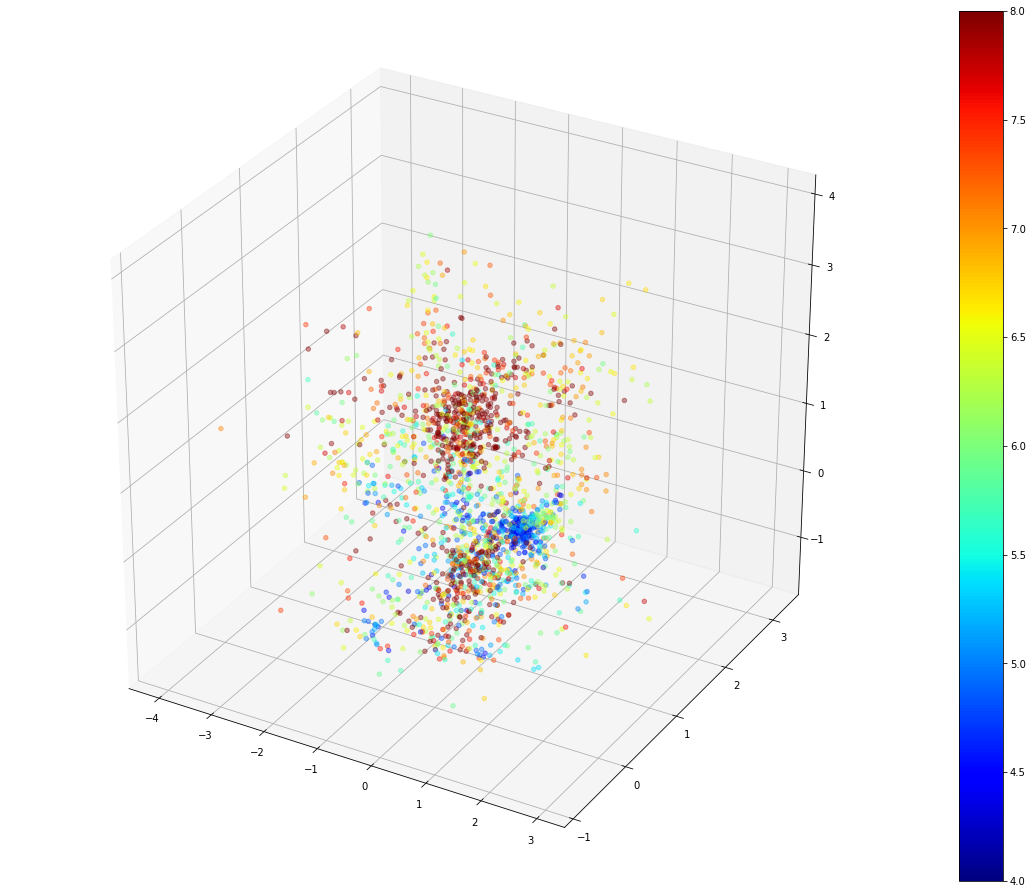

In [37]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection='3d')
color = labels[:2000, 1] # np.array(cm_label[:,2])
base = plt.cm.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=4.0, vmax=8)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=base)
sc = ax.scatter(embeded.cpu()[:,0], embeded.cpu()[:,1], embeded.cpu()[:,2], c=scalarMap.to_rgba(color), alpha=0.4)
scalarMap.set_array(color)
plt.colorbar(scalarMap)

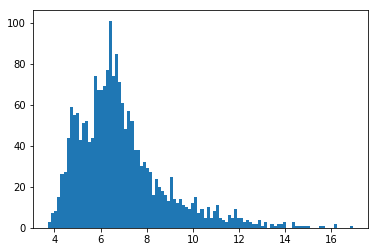

In [26]:
hist, _, _ = plt.hist(labels[:2000,1], bins=100)